In [ ]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e modelo
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving application_record.csv to application_record.csv
Saving credit_record.csv to credit_record.csv


In [ ]:
# Carregar os arquivos
df_app = pd.read_csv('application_record.csv')
df_credit = pd.read_csv('credit_record.csv')

print(df_app.shape)
print(df_credit.shape)
df_app.head()
df_credit.head()

(438557, 18)
(1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [ ]:
# Verificando colunas e tipos
df_app.info()
df_credit.info()

# Verificar valores únicos da coluna 'STATUS'
print(df_credit['STATUS'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
# Filtrar apenas atrasos (STATUS 1 a 5)
df_credit['default'] = df_credit['STATUS'].apply(lambda x: 1 if x in ['1', '2', '3', '4', '5'] else 0)

# Agrupar por ID e contar meses de atraso
df_delay = df_credit.groupby('ID')['default'].sum().reset_index()
df_delay.columns = ['ID', 'months_with_delay']

# Criar variável-alvo: cliente aprovado ou não
df_delay['Approved'] = df_delay['months_with_delay'].apply(lambda x: 0 if x > 0 else 1)

# Juntar dados pessoais + histórico resumido
df_full = pd.merge(df_app, df_delay, on='ID')
print(df_full['Approved'].value_counts())

# Após merge com df_delay:
df_full = pd.merge(df_app, df_delay, on='ID')

# Remover variáveis auxiliares que causam vazamento
df_full = df_full.drop(columns=['months_with_delay'])

# Opcional: se ainda tiver a coluna 'default' ou 'STATUS' por algum motivo
df_full = df_full.drop(columns=['default'], errors='ignore')

Approved
1    32166
0     4291
Name: count, dtype: int64


In [ ]:
# Remover ID
df_full.drop('ID', axis=1, inplace=True)

# Separar X e y
X = df_full.drop('Approved', axis=1)
y = df_full['Approved']

# Separar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Pré-processamento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Corrigido aqui
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

F1-score: 0.9394944803040357
AUC: 0.795321475116774
              precision    recall  f1-score   support

           0       0.56      0.30      0.39      1073
           1       0.91      0.97      0.94      8042

    accuracy                           0.89      9115
   macro avg       0.74      0.64      0.67      9115
weighted avg       0.87      0.89      0.88      9115



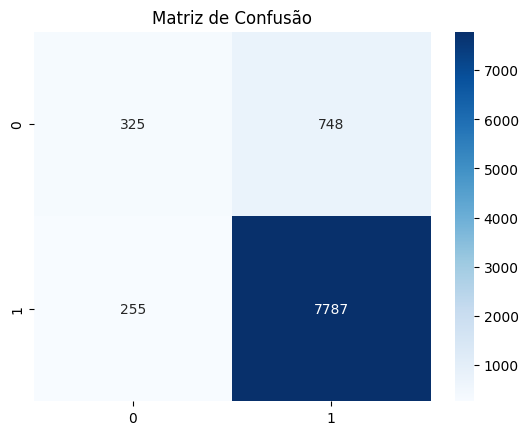

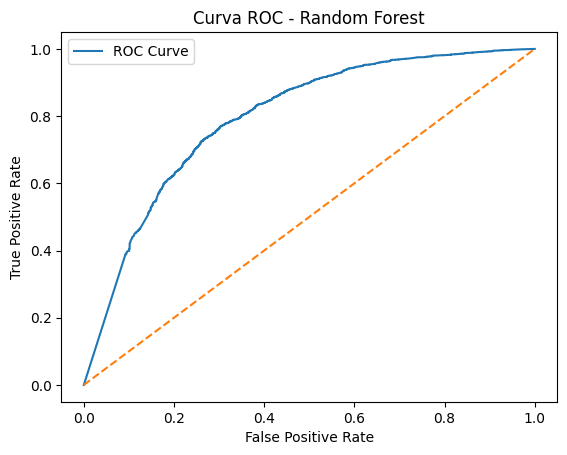

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
y_proba = pipe_rf.predict_proba(X_test)[:, 1]

print("F1-score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.show()

In [ ]:
!pip install imbalanced-learn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

resultados = {}

# 1️⃣ SMOTE
pipe_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipe_smote.fit(X_train, y_train)
y_pred_smote = pipe_smote.predict(X_test)
resultados['SMOTE'] = {
    'F1': f1_score(y_test, y_pred_smote),
    'AUC': roc_auc_score(y_test, pipe_smote.predict_proba(X_test)[:, 1]),
    'Relatório': classification_report(y_test, y_pred_smote),
    'Matriz': confusion_matrix(y_test, y_pred_smote)
}

# 2️⃣ Undersampling
pipe_under = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])
pipe_under.fit(X_train, y_train)
y_pred_under = pipe_under.predict(X_test)
resultados['Undersampling'] = {
    'F1': f1_score(y_test, y_pred_under),
    'AUC': roc_auc_score(y_test, pipe_under.predict_proba(X_test)[:, 1]),
    'Relatório': classification_report(y_test, y_pred_under),
    'Matriz': confusion_matrix(y_test, y_pred_under)
}

# 3️⃣ Class_weight = balanced
pipe_weight = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
pipe_weight.fit(X_train, y_train)
y_pred_weight = pipe_weight.predict(X_test)
resultados['ClassWeight'] = {
    'F1': f1_score(y_test, y_pred_weight),
    'AUC': roc_auc_score(y_test, pipe_weight.predict_proba(X_test)[:, 1]),
    'Relatório': classification_report(y_test, y_pred_weight),
    'Matriz': confusion_matrix(y_test, y_pred_weight)
}

In [ ]:
for metodo, metricas in resultados.items():
    print(f"\n🔍 Método: {metodo}")
    print(f"F1-score: {metricas['F1']:.4f}")
    print(f"AUC: {metricas['AUC']:.4f}")
    print("Matriz de Confusão:")
    print(metricas['Matriz'])
    print("Relatório de Classificação:")
    print(metricas['Relatório'])


🔍 Método: SMOTE
F1-score: 0.9273
AUC: 0.7930
Matriz de Confusão:
[[ 434  639]
 [ 537 7505]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.45      0.40      0.42      1073
           1       0.92      0.93      0.93      8042

    accuracy                           0.87      9115
   macro avg       0.68      0.67      0.68      9115
weighted avg       0.87      0.87      0.87      9115


🔍 Método: Undersampling
F1-score: 0.7901
AUC: 0.7448
Matriz de Confusão:
[[ 718  355]
 [2559 5483]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.22      0.67      0.33      1073
           1       0.94      0.68      0.79      8042

    accuracy                           0.68      9115
   macro avg       0.58      0.68      0.56      9115
weighted avg       0.85      0.68      0.74      9115


🔍 Método: ClassWeight
F1-score: 0.9091
AUC: 0.7917
Matriz de Confusão:
[[ 548  525]
 [ 902 7140

Conclusão

Apesar de SMOTE e ClassWeight apresentarem excelente desempenho na classe 1 (aprovados), ambos mostraram baixa eficácia em identificar corretamente a classe 0 (não aprovados) — ou seja, baixo recall e precisão para os verdadeiros negativos.

Já o Undersampling teve um desempenho superior na classe 0 em termos de recall (0.67), mas perdeu performance na classe 1 e no resultado geral, pois removeu muitos dados da classe majoritária.

Recomendações Finais
Apesar de SMOTE e class_weight='balanced' terem ótimo desempenho na classe 1 (Aprovados), ambos tiveram dificuldades em identificar corretamente os verdadeiros negativos (classe 0 = Não aprovados).

Devido a importância da identificação correta dos não aprovados (classe 0) para o projeto, evitando crédito indevido, os modelos testados na forma que foram usado não aparentam ser as soluções ideais.

algumas abordagens adicionais que podem melhorar isso:

Ajuste de threshold: Testar limiares de decisão diferentes de 0.5.

Técnicas de ensemble mais balanceadas: como BalancedRandomForestClassifier ou EasyEnsemble.

Análise de custos: penalizar mais fortemente os falsos positivos.

GridSearch focado em recall para classe 0.